# GEOtop Calibration Report

In [1]:
# Default

model_path = '../data/testbed/inputs'
timeout = 120
observations_path = '../data/testbed/observations/obs.csv'
parameters_path = '../data/parameters/testbed.csv'
default_parameters = {}
algorithm = 'NGO'
popsize = 2
num_generations = 2
scheduler_file = None
num_workers = 2

In [2]:
from time import strftime, gmtime

import numpy as np
import pandas as pd
import scrapbook as sb
from dask.distributed import Client

from mhpc_project.utils import date_parser, comparison_plots, convergence_plot, kge_cmp, calibrate, delta_mim
from mhpc_project.parameters import UniformSoilParameters as Parameters
from mhpc_project.models import UniformSoilModel as Model

In [3]:
# Glue inputs
sb.glue('model_path', model_path)
sb.glue('observations_path', observations_path)
sb.glue('parameters_path', parameters_path)
sb.glue('timeout', timeout)
sb.glue('default_parameters', default_parameters)
sb.glue('algorithm', algorithm)
sb.glue('popsize', popsize)
sb.glue('num_generations', num_generations)
sb.glue('num_workers', num_workers)

In [4]:
parameters = Parameters(parameters_path, default_parameters)
model = Model(model_path, store=False, timeout=timeout)
observations = pd.read_csv(observations_path,
                           parse_dates=[0],
                           date_parser=date_parser,
                           index_col=0)

In [5]:
# client = Client(scheduler_file=scheduler_file)
client = Client()

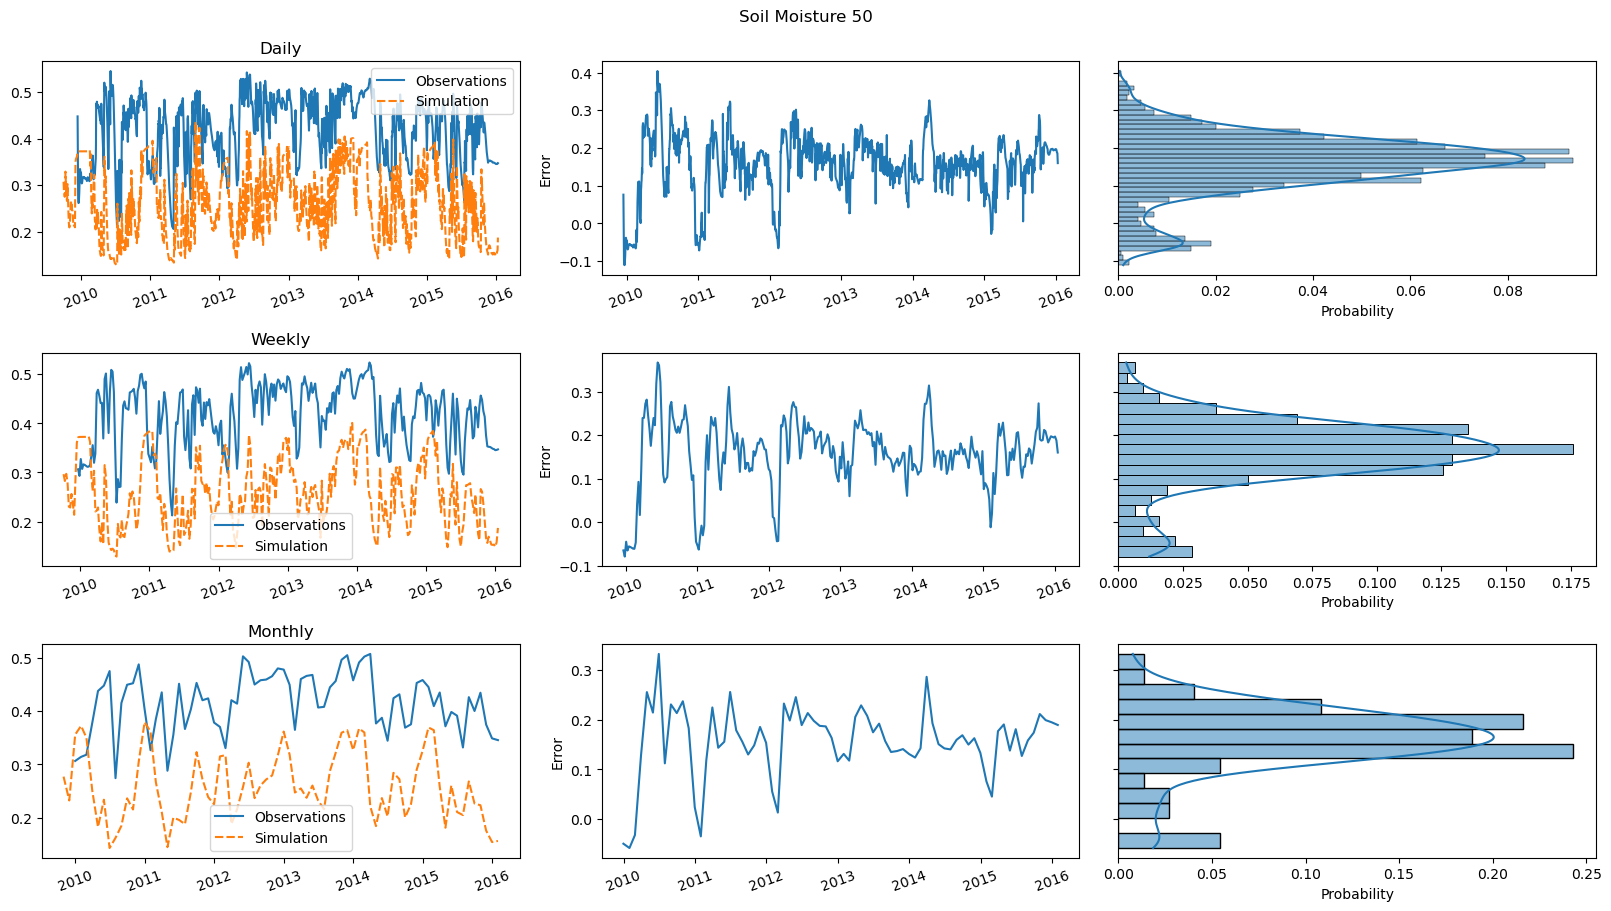

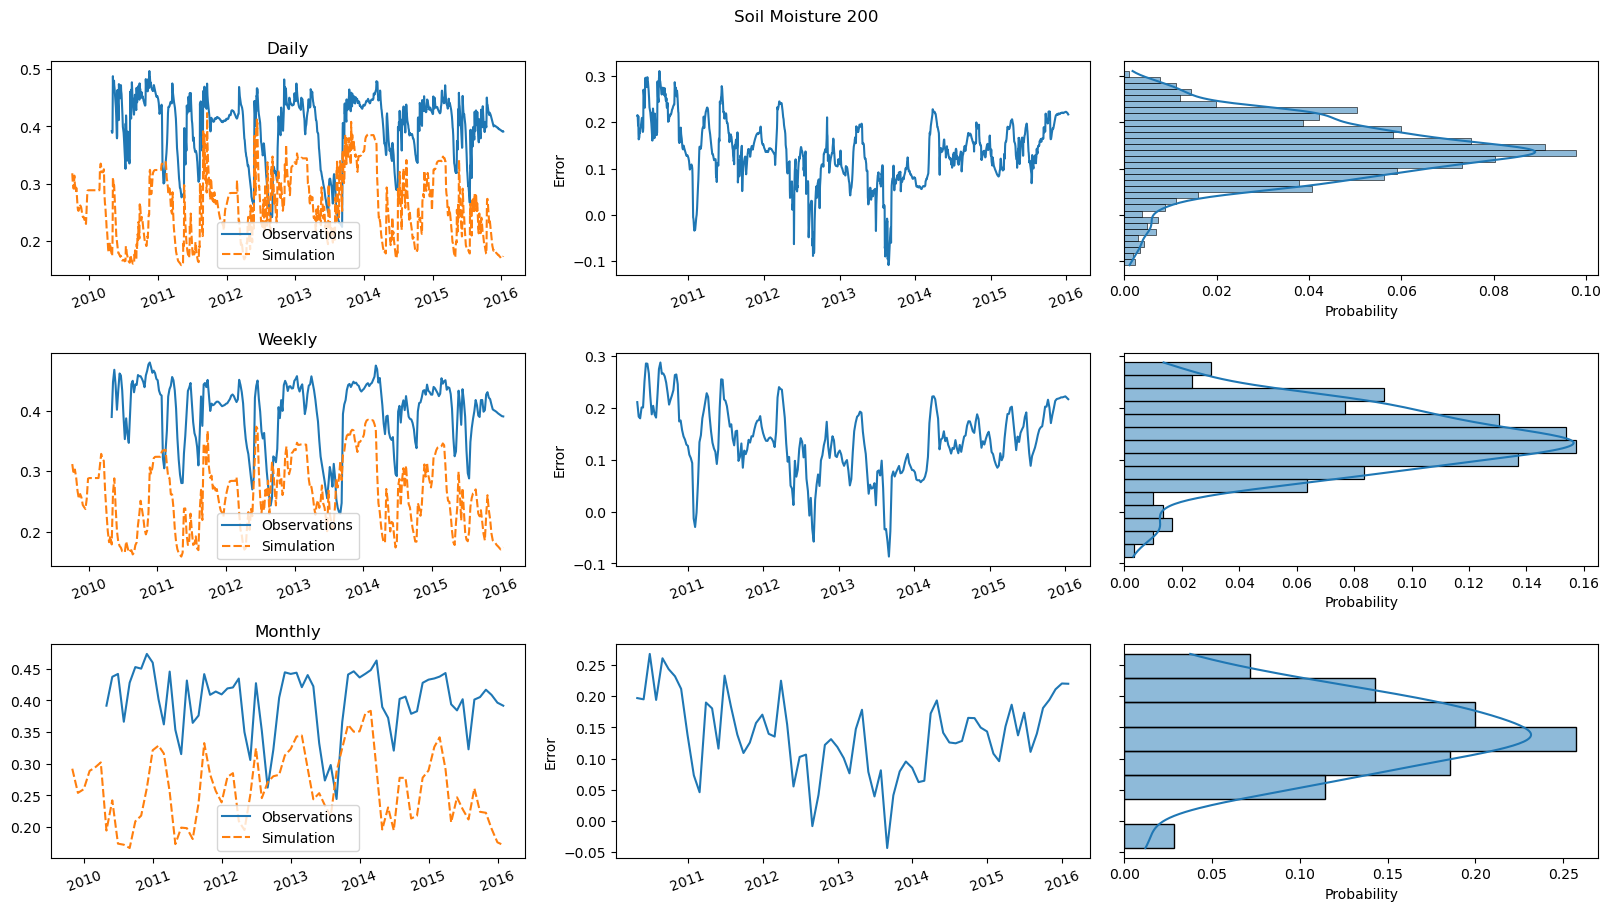

In [6]:
initial_guess = parameters.instrumentation
uncalibrated_output = model(*initial_guess.args, **initial_guess.kwargs)
comparison_plots(uncalibrated_output, observations)

In [7]:
recommendation, predictions, log, elapsed = calibrate(model,
                                                      parameters,
                                                      observations,
                                                      algorithm,
                                                      popsize,
                                                      num_generations,
                                                      client,
                                                      num_workers)
print("elapsed time:", strftime("%T", gmtime(elapsed)))

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=nan, Wed Jan 20 19:47:34 2021)
elapsed time: 00:09:41


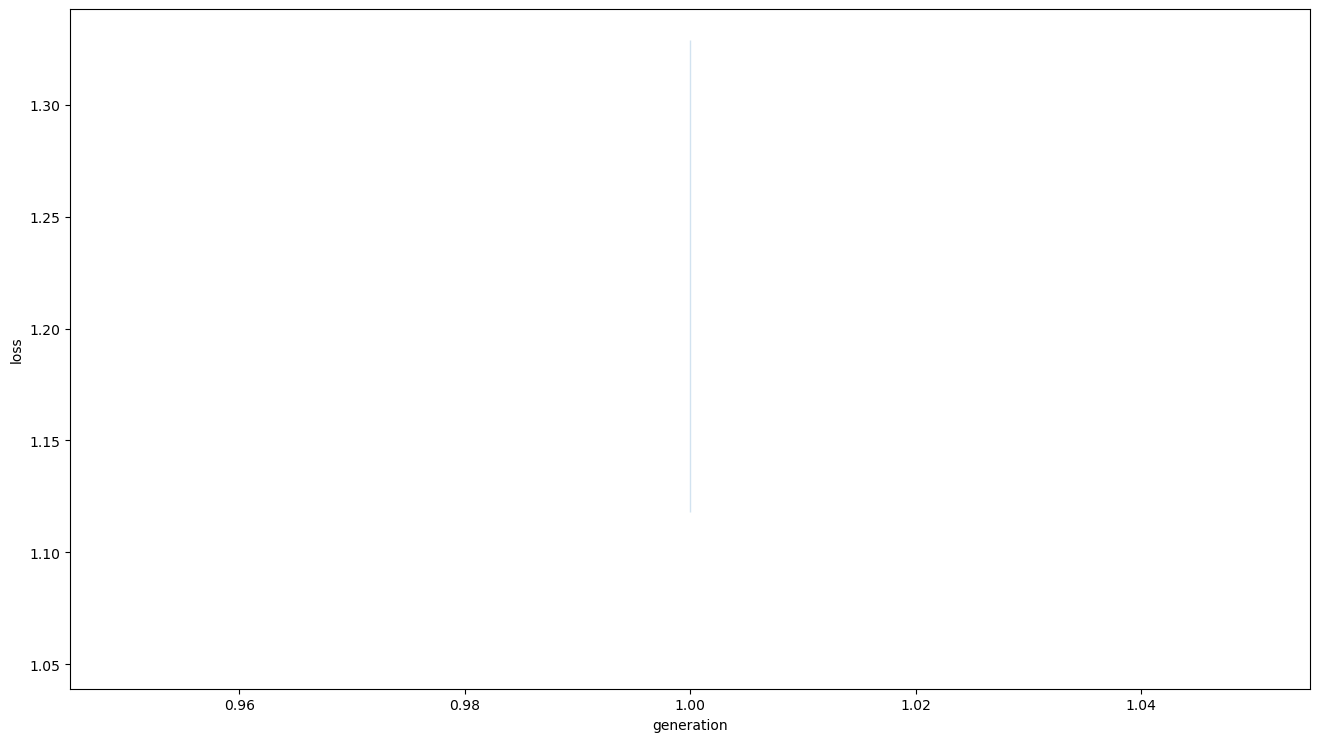

In [8]:
convergence_plot([(x.generation, l) for x, l, _ in log if np.isfinite(l)])

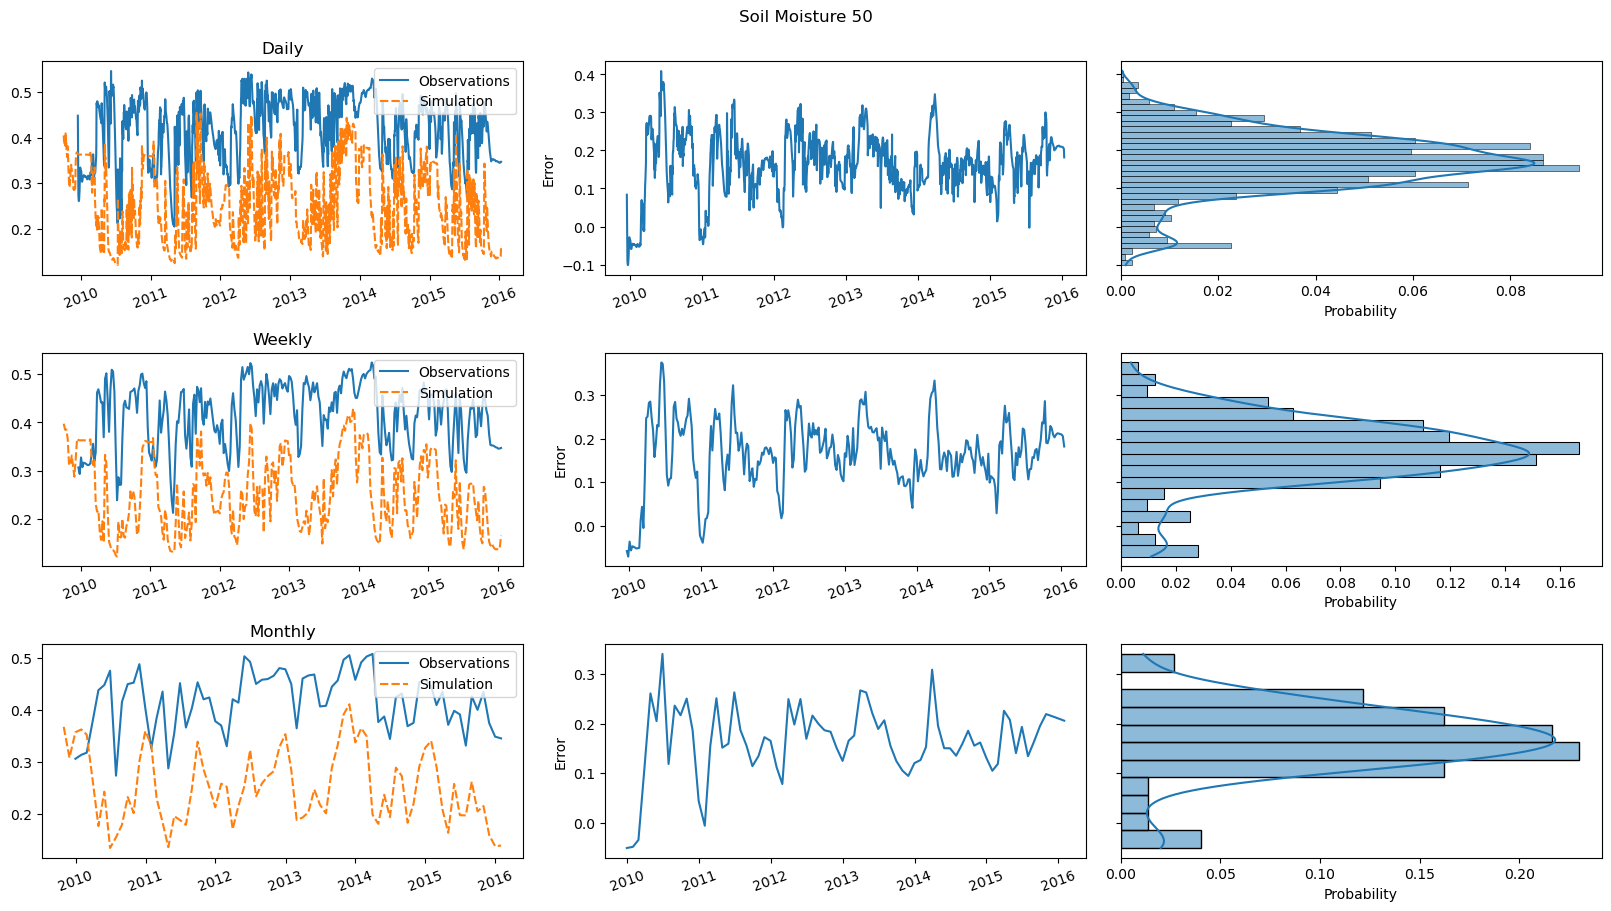

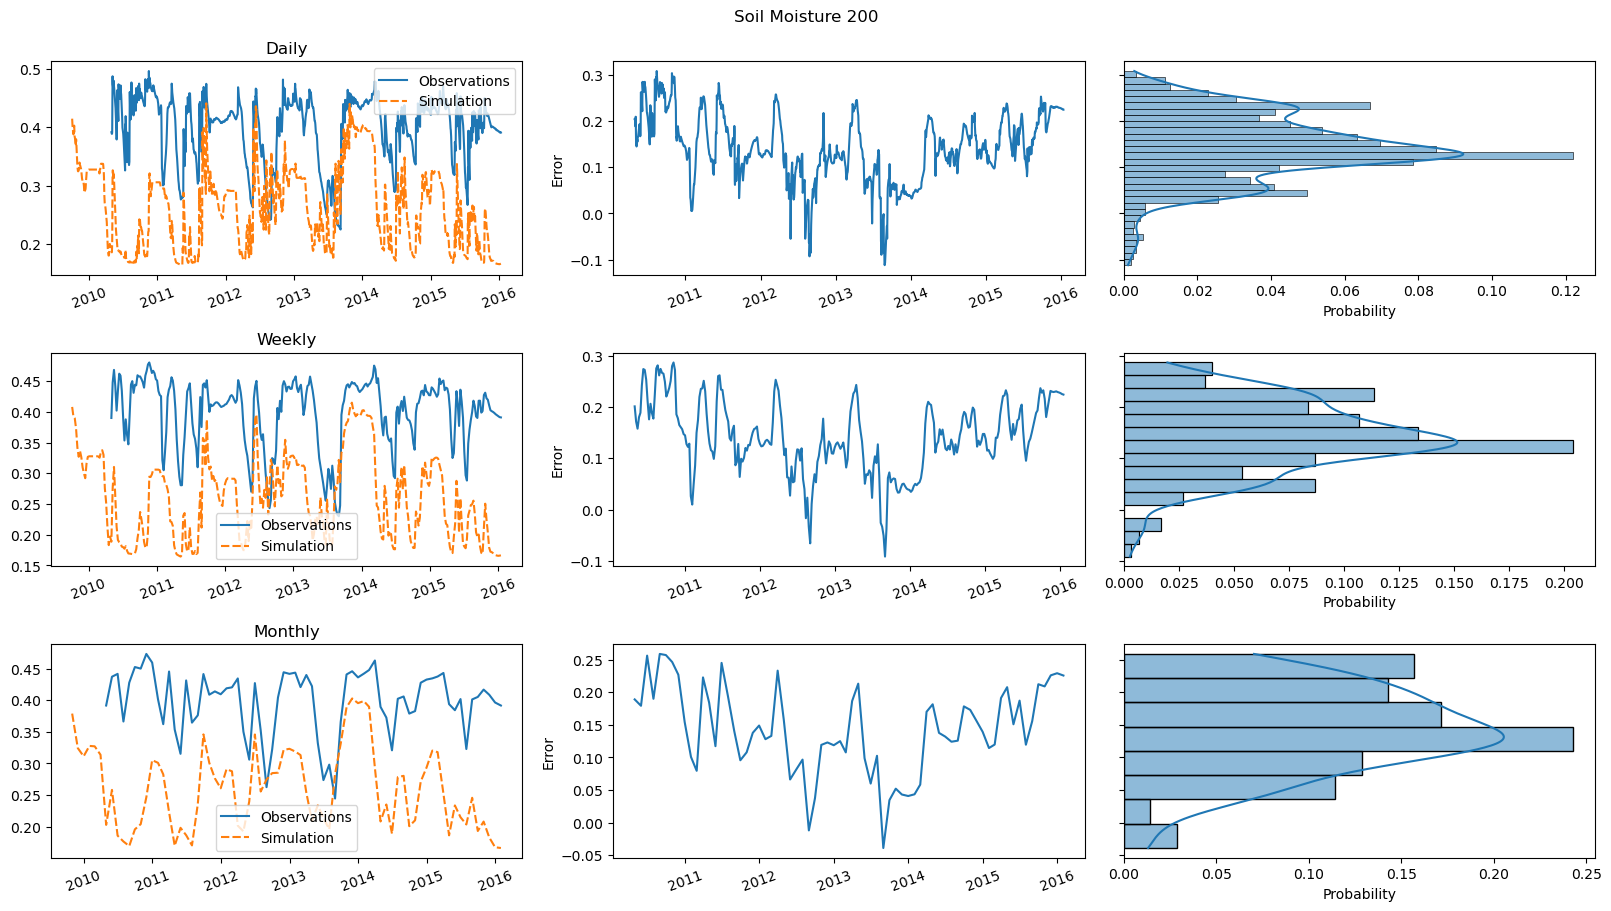

In [9]:
comparison_plots(predictions, observations)

In [10]:
report = delta_mim(parameters, [(x, l) for x, l, t in log if np.isfinite(l)])
report['best'] = parameters.from_instrumentation(recommendation)
report.sort_values('delta', key=np.abs, ascending=False)

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
# Outputs
sb.glue('report', report, 'pandas')
sb.glue('loss', kge_cmp(predictions, observations))
sb.glue('loss_log', [(x.generation, l, t) for (x, l, t) in log])
sb.glue('elapsed_time', elapsed)
